In [45]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import glob
import os
import datetime
from datetime import timedelta, datetime
import scipy
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline
import timeit
from timeit import default_timer as timer
from matplotlib import pyplot
from matplotlib.pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
from functools import reduce
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error
from scipy.cluster.vq import kmeans, kmeans2, whiten
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor  
from sklearn import datasets, linear_model, metrics 
from sklearn.ensemble import RandomForestRegressor

In [3]:
cd C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul

C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul


In [4]:
data = pd.read_csv('ML_HOV_LAT_LONG.csv')
print(data.shape)
#data.head()

(2751, 15)


In [5]:
cd C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\Anomaly Detection

C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\Anomaly Detection


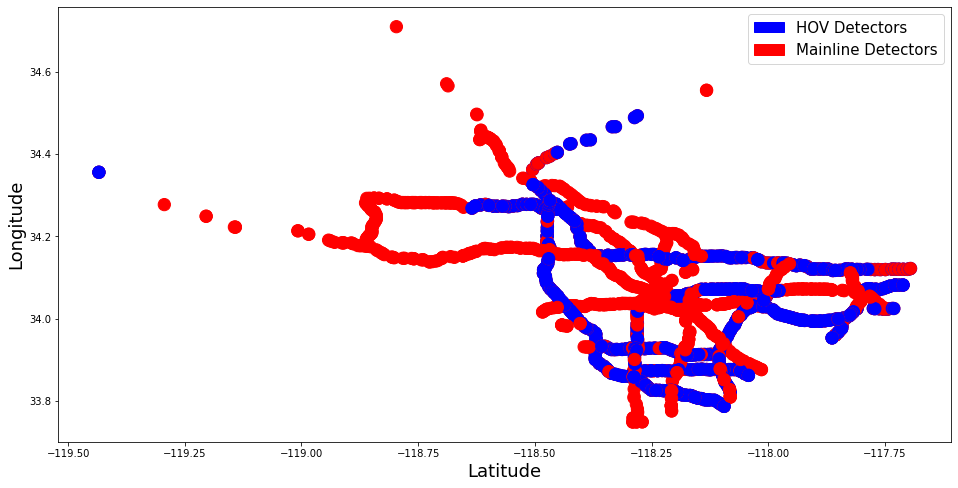

In [6]:
fig = plt.figure(figsize = (16,8))
colors = {'ML':'red', 'HV':'blue'}
plt.scatter(data['LONGITUDE'], data['LATITUDE'],c=data['TYPE'].apply(lambda x: colors[x]),s = 150, edgecolors=None)
plt.xlabel('Latitude',fontsize = 18)
plt.ylabel('Longitude',fontsize = 18)
blue_patch = mpatches.Patch(color='b', label='HOV Detectors')
red_patch = mpatches.Patch(color='r', label='Mainline Detectors')
plt.legend(handles = [blue_patch,red_patch],fontsize = 15)

#plt.savefig('ML_HOv_D7.png')
plt.show()

In [7]:
df = data.copy()
df = df.drop(['DISTRICT','COUNTY','CITY','LENGTH','NAME','USER_ID_1'],axis = 1)
df = df.dropna()
print(df[df.isnull().any(axis=1)])
#df.head()

Empty DataFrame
Columns: [VDS_ID, FWY, DIRECTION, STATE_PM, ABS_PM, LATITUDE, LONGITUDE, TYPE, LANES]
Index: []


In [8]:
## K means clustering of geolocations
from sklearn.cluster import KMeans
kmeans_1 = KMeans(n_clusters=10,random_state=123,max_iter=100)
X = df[['LONGITUDE','LATITUDE']].values
predictions = kmeans_1.fit_predict(X)
clustered = pd.concat([df.reset_index(),
                      pd.DataFrame({'Cluster' :predictions})],
                     axis = 1)
clustered = clustered.drop(['index'],axis = 1)
#clustered.head()

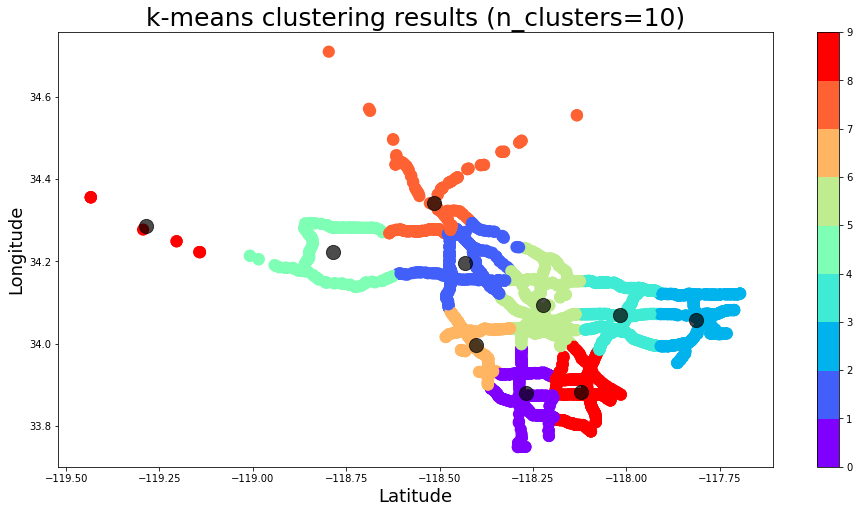

In [9]:
fig = plt.figure(figsize=(16,8))
cmap=plt.cm.rainbow
norm = matplotlib.colors.BoundaryNorm(np.arange(0,10,1), cmap.N)
plt.scatter(clustered['LONGITUDE'], clustered['LATITUDE'], c=clustered['Cluster'],
            cmap=cmap, norm=norm, s=150, edgecolor='none')
plt.colorbar(ticks=np.linspace(0,9,10))
centers = kmeans_1.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='k', s=200, alpha=0.7);
#plt.xlim(2.28, 2.375)
#plt.ylim(48.84, 48.89)
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Longitude', fontsize=18)
plt.title('k-means clustering results (n_clusters=10)', fontsize=25)
#plt.savefig('clustered_ML_HOV_D7.png')
plt.show()

In [10]:
### Now since we have clustered all the mainline and HOV loops into 10 clusters, let's imagine that some of the detectors
### in one of the cluster are not giving good data 

## Lets see how many loops are in every cluster

clustered.Cluster.value_counts()

5    436
8    392
3    359
2    338
1    319
0    317
6    233
7    187
4    158
9     10
Name: Cluster, dtype: int64

In [11]:
cluster5_loops = clustered.loc[clustered['Cluster']==5]
cluster5_loops = cluster5_loops.reset_index(drop = True)
#cluster5_loops.head()

In [12]:
cd C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\Anomaly Detection

C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\Anomaly Detection


In [ ]:
colnames = ["VDS_ID","Lane Count","Loop Count"]

for i in range(1,11):
    colnames.append('Loop_{}_FLOW'.format(i))
    colnames.append('Loop_{}_Occupancy'.format(i))
    colnames.append('Loop_{}_status'.format(i))

health_data_day2 = pd.read_csv('Good_Data_30thSept.csv',sep = ',')
health_data_US101S_day2 = health_data_day2.loc[health_data_day2['Fwy'] == 'US101-S']
health_data_US101S_day2 = health_data_US101S_day2.drop_duplicates(subset=['VDS'],keep = 'last')
health_data_US101S_day2 = health_data_US101S_day2.reset_index(drop = True)
li_lstm = []
li_groups = []
li_complete_groups = []
day1 = pd.DataFrame()
def pre_processing_lstm(day):
    global li_lstm
    global li_groups
    global li_complete_groups
    global day1 
    path = r'C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\\' + day + '\\'
    
    all_files = glob.glob(path + "/*.txt")
    for filename in all_files:
        if  int(filename[-10:-8]) >= 5 and int(filename[-10:-8]) <=21:
            df = pd.read_csv(filename,index_col = None, delimiter = ",",names = colnames ,skiprows = 1)
            df= df.drop(['Lane Count','Loop Count','Loop_1_status','Loop_8_status','Loop_2_status','Loop_3_status',
                         'Loop_4_status','Loop_5_status','Loop_6_status','Loop_7_status','Loop_8_status','Loop_9_status',
                         'Loop_10_status'],axis = 1)
            df['time'] = datetime.strptime(str(int(filename[-18:-4])),'%Y%m%d%H%M%S')
            li_lstm.append(df)
    li_lstm = [df.loc[df['VDS_ID'].isin(health_data_day2.VDS.values)] for df in li_lstm]
    day1 = pd.concat(li_lstm)
    return day1

start = timer()
pre_processing_lstm('20190923')
end = timer()
print(end-start)

print(day1.shape)
day1 = day1.reset_index(drop = True)
#day1.head()

In [14]:
# ### Let us see the detectors on US101 South which are in cluster 5
# cluster5_loops[(cluster5_loops['FWY']==101)].sort_values('ABS_PM').reset_index(drop = True)

Text(0.5, 1.0, 'US101 Cluster5 (Number of Detectors = 43)')

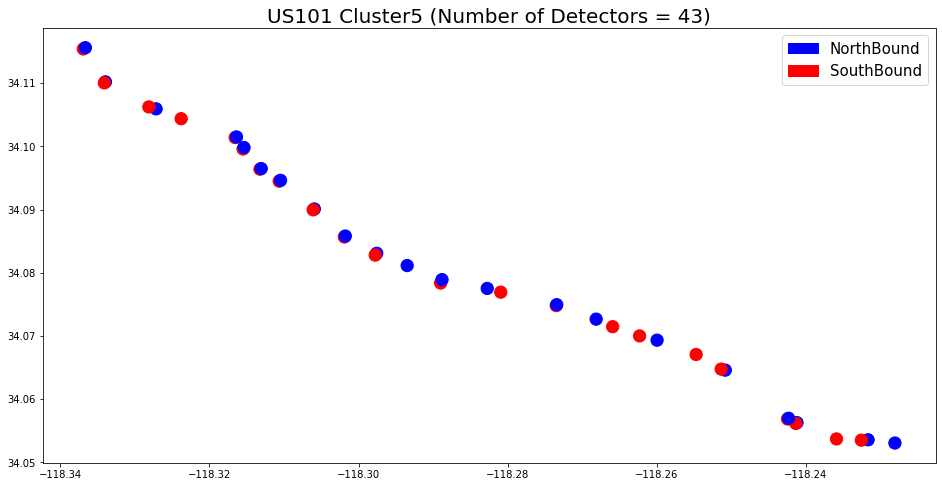

In [15]:
fig = plt.figure(figsize = (16,8))
colors = {'S':'red', 'N':'blue'}
plt.scatter(cluster5_loops[(cluster5_loops['FWY']==101)].sort_values('ABS_PM').reset_index(drop = True)['LONGITUDE'], 
            cluster5_loops[(cluster5_loops['FWY']==101)].sort_values('ABS_PM').reset_index(drop = True)['LATITUDE'],
            c=cluster5_loops[(cluster5_loops['FWY']==101)].sort_values('ABS_PM').reset_index(drop = True)['DIRECTION'].apply(lambda x: colors[x]),
            s = 150, edgecolors=None)
blue_patch = mpatches.Patch(color='b', label='NorthBound')
red_patch = mpatches.Patch(color='r', label='SouthBound')
plt.legend(handles = [blue_patch,red_patch],fontsize = 15)
plt.title('US101 Cluster5 (Number of Detectors = 43)',fontsize = 20)
#plt.savefig('US101_Cluster5.png')

Text(0.5, 1.0, 'All_Routes Cluster5 (Number of Detectors = 436 )')

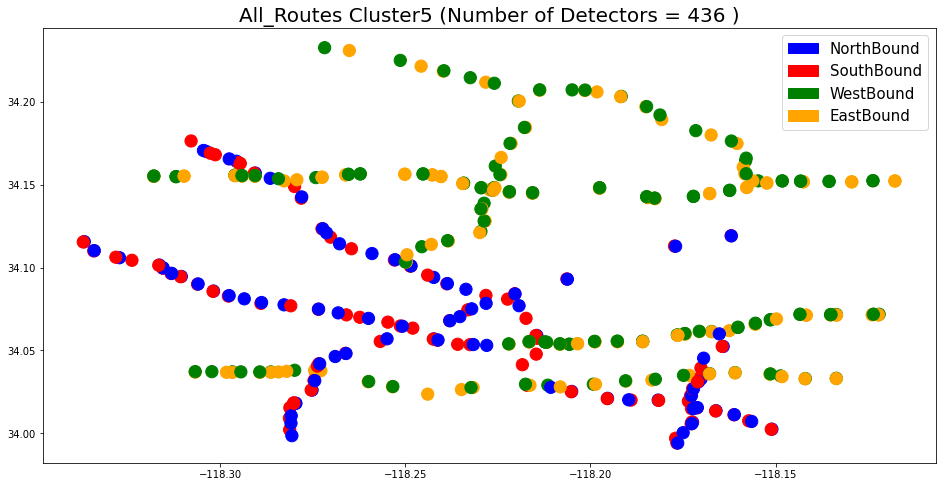

In [16]:
fig = plt.figure(figsize = (16,8))
colors = {'S':'red', 'N':'blue','W':'green','E':'orange'}
plt.scatter(cluster5_loops['LONGITUDE'], cluster5_loops['LATITUDE'],c=cluster5_loops['DIRECTION'].apply(lambda x: colors[x]),s = 150, edgecolors=None)
blue_patch = mpatches.Patch(color='b', label='NorthBound')
red_patch = mpatches.Patch(color='r', label='SouthBound')
green_patch = mpatches.Patch(color='g', label='WestBound')
orange_patch = mpatches.Patch(color='orange', label='EastBound')
plt.legend(handles = [blue_patch,red_patch,green_patch,orange_patch],fontsize = 15)
plt.title('All_Routes Cluster5 (Number of Detectors = 436 )',fontsize = 20)
#plt.savefig('All_loops_Cluster5.png')

<Figure size 1152x576 with 0 Axes>

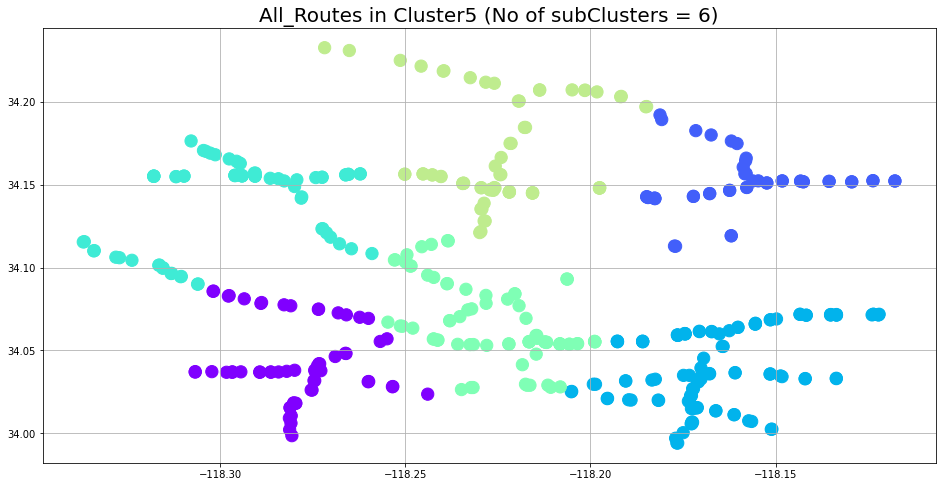

In [17]:
fig = plt.figure(figsize = (16,8))
fig = plt.figure(figsize=(16,8))
cmap=plt.cm.rainbow
norm = matplotlib.colors.BoundaryNorm(np.arange(0,10,1), cmap.N)
coordinates = np.array(cluster5_loops[['LONGITUDE','LATITUDE']])
x, y = kmeans2(whiten(coordinates), 6, iter = 20)  
plt.scatter(coordinates[:,0], coordinates[:,1], c=y,s = 150, edgecolors=None,cmap=cmap,norm=norm)
plt.title('All_Routes in Cluster5 (No of subClusters = 6)',fontsize = 20)
#plt.savefig('Cluster5_subclusters.png')
plt.grid()
plt.show()

In [18]:
cluster5_loops['SubCluster'] = y
print(cluster5_loops.SubCluster.value_counts())
cluster5_loops.head()

2    109
4     78
3     71
5     68
0     61
1     49
Name: SubCluster, dtype: int64


VDS_ID  FWY DIRECTION STATE_PM   ABS_PM   LATITUDE   LONGITUDE TYPE  LANES  \
0  715938    5         N    12.18  128.813  34.002541 -118.150997   ML      4   
1  715944    5         N    13.35  129.983  34.013676 -118.166091   ML      4   
2  715947    5         S    13.67  130.240  34.015325 -118.171270   ML      3   
3  716028   10         E     S.52   16.759  34.055167 -118.216535   ML      3   
4  716063   10         W   R13.53   11.375  34.037129 -118.296691   ML      4   

   Cluster  SubCluster  
0        5           2  
1        5           2  
2        5           2  
3        5           4  
4        5           0

In [ ]:
# cluster5_loops.sort_values('ABS_PM').to_csv('Cluster_SubCluster.csv')

In [ ]:
# cluster5_loops[cluster5_loops['SubCluster']==4].sort_values('ABS_PM')

In [ ]:
# #for i in cluster5_loops.sort_values('ABS_PM').VDS_ID:
# for i in [776480,773062,776328,716069,717052]:
#     temp = day1.loc[day1['VDS_ID']==i]
    
#     print(i,temp.shape)

# day1 = day1.reset_index(drop = True)
# N1 = day1.loc[day1['VDS_ID']==776480].Loop_1_FLOW
# N2 = day1.loc[day1['VDS_ID']==773062].Loop_1_FLOW
# N3 = day1.loc[day1['VDS_ID']==716069].Loop_1_FLOW
# N4 = day1.loc[day1['VDS_ID']==717052].Loop_1_FLOW

In [19]:
cd C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\Anomaly Detection

C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\Anomaly Detection


In [20]:
### This Data set contains information about all the sensors which were reported as 'Good' on 23rd Sept 
### (Adopted from Caltrans website)
health_data = pd.read_csv('Good_Data_23rdSept.csv',sep = ',')
health_data = health_data.drop_duplicates(subset=['VDS'],keep = 'last')

In [21]:
li_processed_files_day1 = []
def pre_processing(day):
    path = r'C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\\' + day + '\\'
    all_files = glob.glob(path + "/*.txt")
    colnames = ["VDS_ID","Lane Count","Loop Count","Loop_1_FLOW","Loop_1_Occupancy","Loop_1_status","Loop_2_FLOW",
                "Loop_2_Occupancy", "Loop_2_status","Loop_3_FLOW","Loop_3_Occupancy","Loop_3_status","Loop_4_FLOW",
                "Loop_4_Occupancy","Loop_4_status","Loop_5_FLOW","Loop_5_Occupancy","Loop_5_status","Loop_6_FLOW",
                "Loop_6_Occupancy","Loop_6_status","Loop_7_FLOW","Loop_7_Occupancy","Loop_7_status","Loop_8_FLOW",
                "Loop_8_Occupancy","Loop_8_status","Loop_9_FLOW","Loop_9_Occuapncy","Loop_9_status","Loop_10_FLOW",
                "Loop_10_Occupancy","Loop_10_status"]
    for filename in all_files:
        if  int(filename[-10:-8]) >= 5 and int(filename[-10:-8]) <=21:        
            df = pd.read_csv(filename,index_col = None, delimiter = ",",names = colnames ,skiprows = 1)
            df= df.drop(['Lane Count','Loop Count','Loop_1_status','Loop_8_status','Loop_2_status','Loop_3_status',
                         'Loop_4_status','Loop_5_status','Loop_6_status','Loop_7_status','Loop_8_status','Loop_9_status',
                         'Loop_10_status'],axis = 1)
            df['time'] = datetime.strptime(str(int(filename[-18:-4])),'%Y%m%d%H%M%S')
            li_processed_files_day1.append(df)
        else:
            continue 
    return li_processed_files_day1


start = timer()
pre_processing('20190923')
end = timer()
print(f'Time required to process files for day 1 : {end-start} seconds')

## Saving the list of dataframes in another list as well just for safety
new_list_day1 = []
new_list_day1 = li_processed_files_day1.copy()
#print(len(new_list_day1))

li_processed_files_day1 = [dataframe.reset_index(drop = True) for dataframe in li_processed_files_day1]

# print(len(li_processed_files_day1))
# print(li_processed_files_day1[0].shape)

li_processed_files_day1 = [df.loc[df['VDS_ID'].isin(cluster5_loops.VDS_ID.values)] for df in li_processed_files_day1]
li_processed_files_day1 = [df.loc[df['VDS_ID'].isin(health_data.VDS.values)] for df in li_processed_files_day1]
# print(li_processed_files_day1[0].shape)

temp_df = pd.DataFrame()
temp_df = pd.concat(li_processed_files_day1)


tg = temp_df.groupby('VDS_ID')

## dropping unnecessary columns

li_groups = []
for name, group in tg:
    group = group[[each for each in group.columns if 'Occupancy' not in each]]
    li_groups.append(group)
    
## Rearranging data to get all the sensor Id as index and all the timestamps as column names

li_complete_groups = []
for dataframe in li_groups:
    dataframe = dataframe[[column for column in dataframe.columns if 'Occuapncy' not in column]]
    dataframe = dataframe.dropna(axis = 1,how = 'all')
    dataframe = dataframe.reset_index(drop = True)
    cols = dataframe.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    dataframe = dataframe[cols]
    dataframe = dataframe.T
    new_header = dataframe.iloc[0]
    dataframe = dataframe[1:]
    dataframe.columns = new_header   
    dataframe.index = dataframe.index + '_' + str(dataframe.iloc[0].values[0])
    dataframe = dataframe[1:]
    li_complete_groups.append(dataframe)
#print(len(li_complete_groups))

### since we have few sensors in every list, get them in a dataframe

data_train = pd.DataFrame()
data_train = pd.concat(li_complete_groups)

#print(data_train.shape)


## Let's see how the data looks like
#data_train.head()

Time required to process files for day 1 : 52.020589857000004 seconds


In [22]:
health_data_day2 = pd.read_csv('Good_Data_30thSept.csv',sep = ',')
health_data_day2 = health_data_day2.drop_duplicates(subset=['VDS'],keep = 'last')

In [23]:
li_processed_files_day2 = []
def pre_processing(day):
    path = r'C:\Users\desh669\OneDrive - PNNL\Documents\Python Scripts\Mobility Rahul\\' + day + '\\'
    all_files = glob.glob(path + "/*.txt")
    colnames = ["VDS_ID","Lane Count","Loop Count","Loop_1_FLOW","Loop_1_Occupancy","Loop_1_status","Loop_2_FLOW",
                "Loop_2_Occupancy", "Loop_2_status","Loop_3_FLOW","Loop_3_Occupancy","Loop_3_status","Loop_4_FLOW",
                "Loop_4_Occupancy","Loop_4_status","Loop_5_FLOW","Loop_5_Occupancy","Loop_5_status","Loop_6_FLOW",
                "Loop_6_Occupancy","Loop_6_status","Loop_7_FLOW","Loop_7_Occupancy","Loop_7_status","Loop_8_FLOW",
                "Loop_8_Occupancy","Loop_8_status","Loop_9_FLOW","Loop_9_Occuapncy","Loop_9_status","Loop_10_FLOW",
                "Loop_10_Occupancy","Loop_10_status"]
    for filename in all_files:
        if  int(filename[-10:-8]) >= 5 and int(filename[-10:-8]) <=21:        
            df = pd.read_csv(filename,index_col = None, delimiter = ",",names = colnames ,skiprows = 1)
            df= df.drop(['Lane Count','Loop Count','Loop_1_status','Loop_8_status','Loop_2_status','Loop_3_status',
                         'Loop_4_status','Loop_5_status','Loop_6_status','Loop_7_status','Loop_8_status','Loop_9_status',
                         'Loop_10_status'],axis = 1)
            df['time'] = datetime.strptime(str(int(filename[-18:-4])),'%Y%m%d%H%M%S')
            li_processed_files_day2.append(df)
        else:
            continue 
    return li_processed_files_day2


start = timer()
pre_processing('20190930')
end = timer()
print(f'Time required to process files for day 2 : {end-start} seconds')

## Saving the list of dataframes in another list as well just for safety
new_list_day2 = []
new_list_day2 = li_processed_files_day2.copy()
#print(len(new_list_day1))

li_processed_files_day2 = [dataframe.reset_index(drop = True) for dataframe in li_processed_files_day2]

# print(len(li_processed_files_day2))
# print(li_processed_files_day2[0].shape)

li_processed_files_day2 = [df.loc[df['VDS_ID'].isin(cluster5_loops.VDS_ID.values)] for df in li_processed_files_day2]
li_processed_files_day2 = [df.loc[df['VDS_ID'].isin(health_data_day2.VDS.values)] for df in li_processed_files_day2]
#print(li_processed_files_day2[0].shape)

temp_df = pd.DataFrame()
temp_df = pd.concat(li_processed_files_day2)


tg = temp_df.groupby('VDS_ID')

## dropping unnecessary columns

li_groups = []
for name, group in tg:
    group = group[[each for each in group.columns if 'Occupancy' not in each]]
    li_groups.append(group)
    
## Rearranging data to get all the sensor Id as index and all the timestamps as column names

li_complete_groups = []
for dataframe in li_groups:
    dataframe = dataframe[[column for column in dataframe.columns if 'Occuapncy' not in column]]
    dataframe = dataframe.dropna(axis = 1,how = 'all')
    dataframe = dataframe.reset_index(drop = True)
    cols = dataframe.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    dataframe = dataframe[cols]
    dataframe = dataframe.T
    new_header = dataframe.iloc[0]
    dataframe = dataframe[1:]
    dataframe.columns = new_header   
    dataframe.index = dataframe.index + '_' + str(dataframe.iloc[0].values[0])
    dataframe = dataframe[1:]
    li_complete_groups.append(dataframe)
#print(len(li_complete_groups))

### since we have few sensors in every list, get them in a dataframe
data_test = pd.DataFrame()
data_test = pd.concat(li_complete_groups)
#print(data_KNN.shape)



## Let's see how the data looks like
print(data_test.shape)
#data_test.head()

Time required to process files for day 2 : 47.32447856099998 seconds
(557, 2040)


In [25]:
print(data_train.shape)
print(data_test.shape)

(540, 2019)
(557, 2040)


In [26]:
data_train = data_train[data_train.index.isin(data_test.index)]
print(data_train.shape)
print(data_test.shape)

(513, 2019)
(557, 2040)


In [33]:
available_loops = [int(i[12:19]) for i in data_train.index]

available_loops = list(set(available_loops))

print(len(available_loops))

153


In [34]:
loops_cluster5  = list(cluster5_loops.VDS_ID.values)
print(len(loops_cluster5))

436


In [29]:
#cluster5_loops.sort_values('ABS_PM').to_csv('Cluster5_Subclusters.csv')

In [37]:
loops_for_analysis = list(set(available_loops) & set(loops_cluster5))
print(len(loops_for_analysis))

153


In [40]:
df = pd.DataFrame(loops_for_analysis)
df.to_csv('clustering_analysis.csv')
df.head()

0
0  763429
1  716328
2  716331
3  716337
4  716339

In [71]:
### This is for training the LR model 

### Get the training data
train  = pd.DataFrame(data_train.T.Loop_1_FLOW_767750)
train['N1'] = data_train.T.Loop_1_FLOW_760650
train['N2'] = data_train.T.Loop_1_FLOW_773012
train['N3'] = data_train.T.Loop_1_FLOW_767759
train['N4'] = data_train.T.Loop_1_FLOW_767767
train.index = data_train.columns
train = train.fillna(0)

## Get the testing data
valid = pd.DataFrame(data_test.T.Loop_1_FLOW_767750)
valid['N1'] = data_test.T.Loop_1_FLOW_760650
valid['N2'] = data_test.T.Loop_1_FLOW_773012
valid['N3'] = data_test.T.Loop_1_FLOW_767759
valid['N4'] = data_test.T.Loop_1_FLOW_767767
valid.index = data_test.columns
valid = valid.fillna(0)

print(train.head())
print(valid.head())

                     Loop_1_FLOW_767750   N1   N2   N3   N4
time                                                       
2019-09-23 05:00:00                 3.0  1.0  3.0  2.0  1.0
2019-09-23 05:00:30                 8.0  0.0  1.0  1.0  0.0
2019-09-23 05:01:00                 1.0  2.0  3.0  1.0  0.0
2019-09-23 05:01:30                 3.0  0.0  7.0  0.0  0.0
2019-09-23 05:02:00                 4.0  1.0  2.0  1.0  0.0
                     Loop_1_FLOW_767750   N1   N2   N3   N4
time                                                       
2019-09-30 05:00:00                 5.0  3.0  3.0  0.0  0.0
2019-09-30 05:00:30                 3.0  0.0  1.0  4.0  0.0
2019-09-30 05:01:00                 2.0  0.0  8.0  1.0  2.0
2019-09-30 05:01:30                 5.0  0.0  3.0  2.0  0.0
2019-09-30 05:02:00                 2.0  5.0  3.0  4.0  1.0


In [72]:
X_train = train.drop(['Loop_1_FLOW_767750'],axis = 1)
y_train = train['Loop_1_FLOW_767750']

X_test = valid.drop(['Loop_1_FLOW_767750'],axis = 1)
y_test = valid['Loop_1_FLOW_767750']

In [73]:
start = timer()

#create linear regression object 
reg = linear_model.LinearRegression() 
  
# train the model using the training sets 
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

end = timer()

print(end-start)

0.012553050000860821


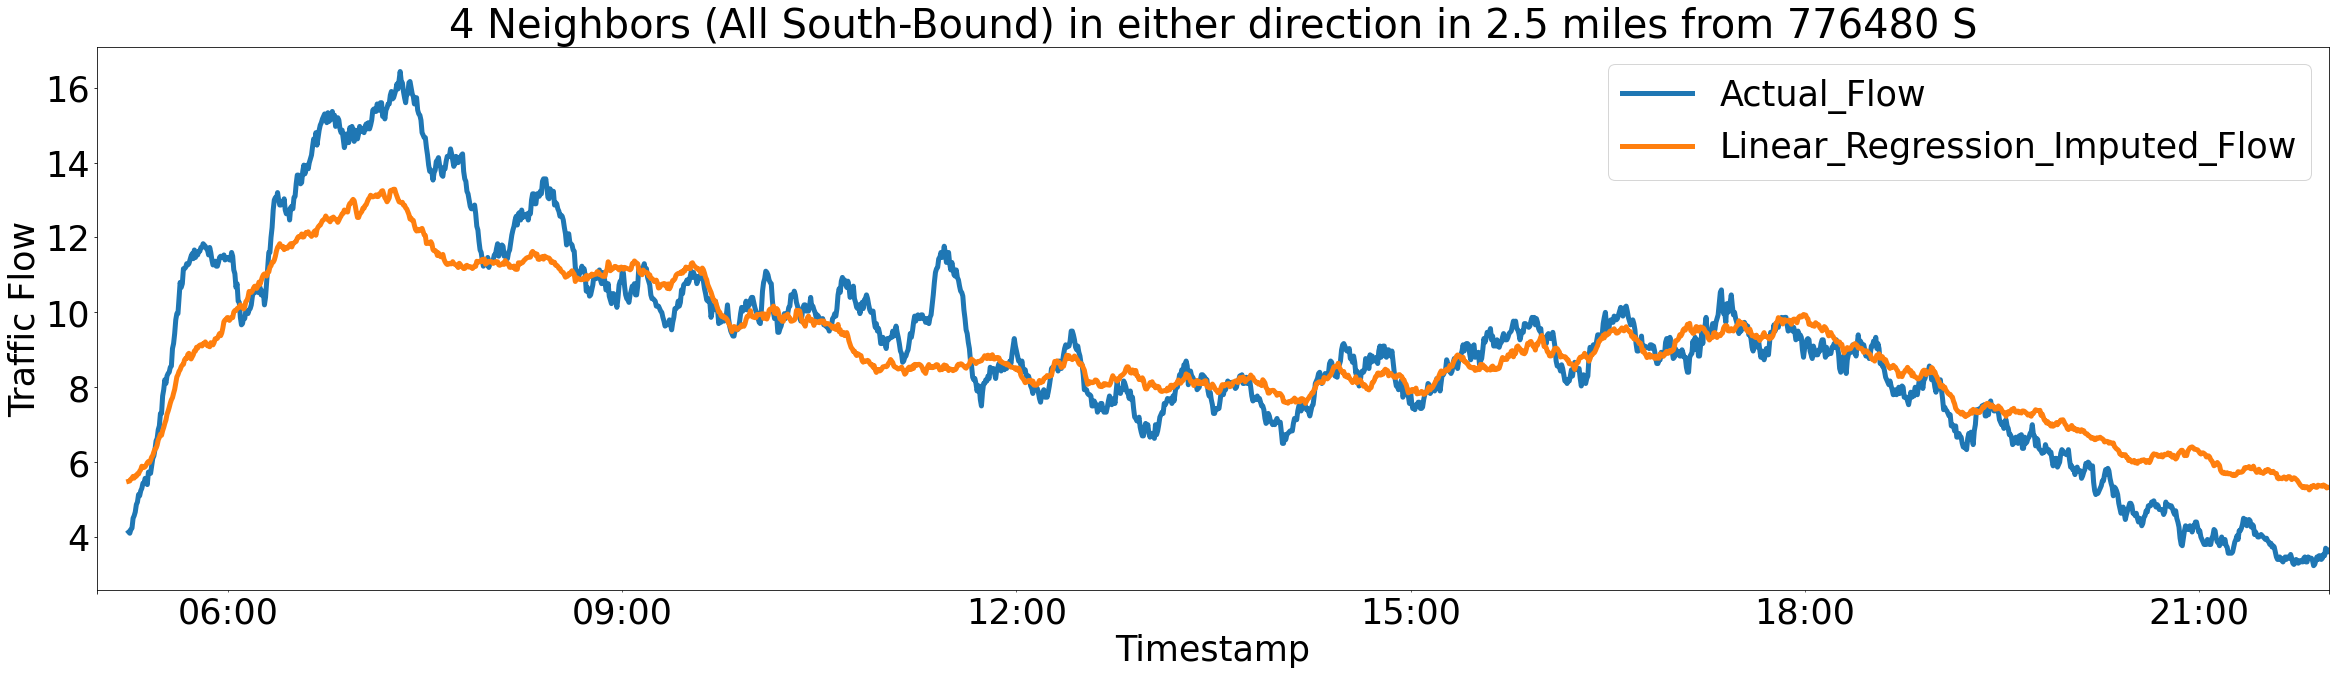

In [75]:
df1 = pd.DataFrame({'Actual_Flow': y_test,'Linear_Regression_Imputed_Flow' : y_pred})

y  = df1.columns
for column in y:
    df1[column].rolling(30).mean().plot(figsize=(40,10),linewidth=5,fontsize=35)
    plt.legend(y,fontsize = 35)
    plt.xlabel('Timestamp',fontsize = 35)
    plt.ylabel('Traffic Flow',fontsize = 35)
    plt.xticks(rotation = 10)
    plt.title('4 Neighbors (All South-Bound) in either direction in 2.5 miles from 776480 S',fontsize = 40)
    plt.savefig('linear_regression_subcluster_3.png')